In [0]:
print(1)

1


In [0]:
#@title
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install torch torchvision
!pip install --no-cache-dir -I pillow
!pip install astropy --no-deps

    100% |████████████████████████████████| 519.5MB 31kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x58e5a000 @  0x7f2842d922a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 25.1MB/s 
    100% |████████████████████████████████| 2.0MB 5.6MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 2.0MB 64.6MB/s 
    100% |████████████████████████████████| 6.0MB 6.3MB/s 


In [0]:
#!rm -rf ~/.nv

In [0]:
#@title
from __future__ import print_function
import matplotlib.pyplot as plt
from __future__ import print_function
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import sys

import numpy as np
from PIL import Image
import PIL
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval as zscale

import argparse
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import torch.optim

from skimage.measure import compare_psnr
%matplotlib inline

import argparse
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import torch.optim

from skimage.measure import compare_psnr
from astropy.modeling.models import Gaussian2D

In [0]:
from astropy.visualization import (ZScaleInterval, ImageNormalize)
from scipy.ndimage.filters import gaussian_filter


In [0]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

In [0]:
torch.cuda.is_available()

True

In [0]:
#@title
from scipy.misc import imresize 
def load_fits(path):
    """Load fits file."""
    f = fits.open(path)
    return f

def get_data(path, imsize=-1):
    """Load an image and resize to a specific size. 
    Args: 
        path: path to image
        imsize: tuple or scalar with dimensions; -1 for `no resize`
    """
    f = load_fits(path)
    d = f[0].data

    if isinstance(imsize, int):
        imsize = (imsize, imsize)

    if imsize[0]!= -1 and d.shape != imsize:
        if imsize[0] > d.shape[0]:
            d = imresize(d,imsize, 'bicubic')
        else:
            d = imresize(d,imsize, 'lanczos')
    
    return f, d

def crop_center(img,cropx,cropy):
    """centre crops numpy array
    """
    x,y = img.shape
    startx = int(x/2-(cropx/2))
    starty = int(y/2-(cropy/2))
    return img[startx:startx+cropx,starty:starty+cropy]

def load_LR_HR_fits_sr(fname, imsize, enforse_div32=None):
    '''Loads an image, resizes it, center crops and downscales.
    Args: 
        fname: path to the image
        imsize: new size for the image, -1 for no resizing
        factor: downscaling factor
        enforse_div32: if 'CROP' center crops an image, so that its dimensions are divisible by 32.
    '''
    fits_orig, data_orig = get_data(fname, -1)

    if imsize != -1:
        fits_orig, data_orig = get_data(fname, imsize)
        
    # For comparison with GT
    if enforse_div32 == 'CROP':
        new_size = (data_orig.shape[0] - data_orig.shape[0] % 32, 
                    data_orig.shape[1] - data_orig.shape[1] % 32)

        data_crop = crop_center(data_orig,new_size[0],new_size[1])
    else:
        data_crop = data_orig
        
    return {    'orig_np':  data_orig,
                'crop_np': data_crop
}
  
def get_noise(input_depth, method, spatial_size, noise_type='u', var=1./10):
    """Returns a pytorch.Tensor of size (1 x `input_depth` x `spatial_size[0]` x `spatial_size[1]`) 
    initialized in a specific way.
    Args:
        input_depth: number of channels in the tensor
        method: `noise` for fillting tensor with noise; `meshgrid` for np.meshgrid
        spatial_size: spatial size of the tensor to initialize
        noise_type: 'u' for uniform; 'n' for normal
        var: a factor, a noise will be multiplicated by. Basically it is standard deviation scaler. 
    """
    if isinstance(spatial_size, int):
        spatial_size = (spatial_size, spatial_size)
    if method == 'noise':
        shape = [1, input_depth, spatial_size[0], spatial_size[1]]
        net_input = torch.zeros(shape)
        
        fill_noise(net_input, noise_type)
        net_input *= var            
    elif method == 'meshgrid': 
        assert input_depth == 2
        X, Y = np.meshgrid(np.arange(0, spatial_size[1])/float(spatial_size[1]-1), np.arange(0, spatial_size[0])/float(spatial_size[0]-1))
        meshgrid = np.concatenate([X[None,:], Y[None,:]])
        net_input=  np_to_torch(meshgrid)
    else:
        assert False
    return net_input

def fill_noise(x, noise_type):
    """Fills tensor `x` with noise of type `noise_type`."""
    if noise_type == 'u':
        x.uniform_()
    elif noise_type == 'n':
        x.normal_() 
    else:
        assert False
        
import torch.nn as nn

def get_net(input_depth, NET_TYPE, pad, upsample_mode, n_channels=3, act_fun='LeakyReLU', skip_n33d=128, skip_n33u=128, skip_n11=4, num_scales=5, downsample_mode='stride'):
    if NET_TYPE == 'ResNet':
        # TODO
        net = ResNet(input_depth, 3, 10, 16, 1, nn.BatchNorm2d, False)
    elif NET_TYPE == 'skip':
        net = skip(input_depth, n_channels, num_channels_down = [skip_n33d]*num_scales if isinstance(skip_n33d, int) else skip_n33d,
                                            num_channels_up =   [skip_n33u]*num_scales if isinstance(skip_n33u, int) else skip_n33u,
                                            num_channels_skip = [skip_n11]*num_scales if isinstance(skip_n11, int) else skip_n11, 
                                            upsample_mode=upsample_mode, downsample_mode=downsample_mode,
                                            need_sigmoid=True, need_bias=True, pad=pad, act_fun=act_fun)

    elif NET_TYPE == 'texture_nets':
        net = get_texture_nets(inp=input_depth, ratios = [32, 16, 8, 4, 2, 1], fill_noise=False,pad=pad)

    elif NET_TYPE =='UNet':
        net = UNet(num_input_channels=input_depth, num_output_channels=3, 
                   feature_scale=4, more_layers=0, concat_x=False,
                   upsample_mode=upsample_mode, pad=pad, norm_layer=nn.BatchNorm2d, need_sigmoid=True, need_bias=True)
    elif NET_TYPE == 'identity':
        assert input_depth == 3
        net = nn.Sequential()
    else:
        assert False

    return net
  
def skip(
        num_input_channels=2, num_output_channels=3, 
        num_channels_down=[16, 32, 64, 128, 128], num_channels_up=[16, 32, 64, 128, 128], num_channels_skip=[4, 4, 4, 4, 4], 
        filter_size_down=3, filter_size_up=3, filter_skip_size=1,
        need_sigmoid=True, need_bias=True, 
        pad='zero', upsample_mode='nearest', downsample_mode='stride', act_fun='LeakyReLU', 
        need1x1_up=True):
    """Assembles encoder-decoder with skip connections.
    Arguments:
        act_fun: Either string 'LeakyReLU|Swish|ELU|none' or module (e.g. nn.ReLU)
        pad (string): zero|reflection (default: 'zero')
        upsample_mode (string): 'nearest|bilinear' (default: 'nearest')
        downsample_mode (string): 'stride|avg|max|lanczos2' (default: 'stride')
    """
    assert len(num_channels_down) == len(num_channels_up) == len(num_channels_skip)

    n_scales = len(num_channels_down) 

    if not (isinstance(upsample_mode, list) or isinstance(upsample_mode, tuple)) :
        upsample_mode   = [upsample_mode]*n_scales

    if not (isinstance(downsample_mode, list)or isinstance(downsample_mode, tuple)):
        downsample_mode   = [downsample_mode]*n_scales
    
    if not (isinstance(filter_size_down, list) or isinstance(filter_size_down, tuple)) :
        filter_size_down   = [filter_size_down]*n_scales

    if not (isinstance(filter_size_up, list) or isinstance(filter_size_up, tuple)) :
        filter_size_up   = [filter_size_up]*n_scales

    last_scale = n_scales - 1 

    cur_depth = None

    model = nn.Sequential()
    model_tmp = model

    input_depth = num_input_channels
    for i in range(len(num_channels_down)):

        deeper = nn.Sequential()
        skip = nn.Sequential()

        if num_channels_skip[i] != 0:
            model_tmp.add(Concat(1, skip, deeper))
        else:
            model_tmp.add(deeper)
        
        model_tmp.add(bn(num_channels_skip[i] + (num_channels_up[i + 1] if i < last_scale else num_channels_down[i])))

        if num_channels_skip[i] != 0:
            skip.add(conv(input_depth, num_channels_skip[i], filter_skip_size, bias=need_bias, pad=pad))
            skip.add(bn(num_channels_skip[i]))
            skip.add(act(act_fun))
            
        # skip.add(Concat(2, GenNoise(nums_noise[i]), skip_part))

        deeper.add(conv(input_depth, num_channels_down[i], filter_size_down[i], 2, bias=need_bias, pad=pad, downsample_mode=downsample_mode[i]))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        deeper.add(conv(num_channels_down[i], num_channels_down[i], filter_size_down[i], bias=need_bias, pad=pad))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        deeper_main = nn.Sequential()

        if i == len(num_channels_down) - 1:
            # The deepest
            k = num_channels_down[i]
        else:
            deeper.add(deeper_main)
            k = num_channels_up[i + 1]

        deeper.add(nn.Upsample(scale_factor=2, mode=upsample_mode[i]))

        model_tmp.add(conv(num_channels_skip[i] + k, num_channels_up[i], filter_size_up[i], 1, bias=need_bias, pad=pad))
        model_tmp.add(bn(num_channels_up[i]))
        model_tmp.add(act(act_fun))


        if need1x1_up:
            model_tmp.add(conv(num_channels_up[i], num_channels_up[i], 1, bias=need_bias, pad=pad))
            model_tmp.add(bn(num_channels_up[i]))
            model_tmp.add(act(act_fun))

        input_depth = num_channels_down[i]
        model_tmp = deeper_main

    model.add(conv(num_channels_up[0], num_output_channels, 1, bias=need_bias, pad=pad))
    if need_sigmoid:
        model.add(nn.Sigmoid())
    return model
  
def act(act_fun = 'LeakyReLU'):
    '''
        Either string defining an activation function or module (e.g. nn.ReLU)
    '''
    if isinstance(act_fun, str):
        if act_fun == 'LeakyReLU':
            return nn.LeakyReLU(0.2, inplace=True)
        elif act_fun == 'Swish':
            return Swish()
        elif act_fun == 'ELU':
            return nn.ELU()
        elif act_fun == 'none':
            return nn.Sequential()
        else:
            assert False
    else:
        return act_fun()


def bn(num_features):
    return nn.BatchNorm2d(num_features)


def conv(in_f, out_f, kernel_size, stride=1, bias=True, pad='zero', downsample_mode='stride'):
    downsampler = None
    if stride != 1 and downsample_mode != 'stride':

        if downsample_mode == 'avg':
            downsampler = nn.AvgPool2d(stride, stride)
        elif downsample_mode == 'max':
            downsampler = nn.MaxPool2d(stride, stride)
        elif downsample_mode  in ['lanczos2', 'lanczos3']:
            downsampler = Downsampler(n_planes=out_f, factor=stride, kernel_type=downsample_mode, phase=0.5, preserve_size=True)
        else:
            assert False

        stride = 1

    padder = None
    to_pad = int((kernel_size - 1) / 2)
    if pad == 'reflection':
        padder = nn.ReflectionPad2d(to_pad)
        to_pad = 0
  
    convolver = nn.Conv2d(in_f, out_f, kernel_size, stride, padding=to_pad, bias=bias)


    layers = filter(lambda x: x is not None, [padder, convolver, downsampler])
    return nn.Sequential(*layers)
  
  
def add_module(self, module):
    self.add_module(str(len(self) + 1), module)
    
torch.nn.Module.add = add_module

class Concat(nn.Module):
    def __init__(self, dim, *args):
        super(Concat, self).__init__()
        self.dim = dim

        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

    def forward(self, input):
        inputs = []
        for module in self._modules.values():
            inputs.append(module(input))

        inputs_shapes2 = [x.shape[2] for x in inputs]
        inputs_shapes3 = [x.shape[3] for x in inputs]        

        if np.all(np.array(inputs_shapes2) == min(inputs_shapes2)) and np.all(np.array(inputs_shapes3) == min(inputs_shapes3)):
            inputs_ = inputs
        else:
            target_shape2 = min(inputs_shapes2)
            target_shape3 = min(inputs_shapes3)

            inputs_ = []
            for inp in inputs: 
                diff2 = (inp.size(2) - target_shape2) // 2 
                diff3 = (inp.size(3) - target_shape3) // 2 
                inputs_.append(inp[:, :, diff2: diff2 + target_shape2, diff3:diff3 + target_shape3])

        return torch.cat(inputs_, dim=self.dim)

    def __len__(self):
        return len(self._modules)

def np_to_torch(img_np):
    '''Converts image in numpy.array to torch.Tensor.
    From C x W x H [0..1] to  C x W x H [0..1]
    '''
    return torch.from_numpy(img_np)[None, :]

def torch_to_np(img_var):
    '''Converts an image in torch.Tensor format to np.array.
    From 1 x C x W x H [0..1] to  C x W x H [0..1]
    '''
    return img_var.detach().cpu().numpy()[0]


def optimize(optimizer_type, parameters, closure, LR, num_iter):
    """Runs optimization loop.
    Args:
        optimizer_type: 'LBFGS' of 'adam'
        parameters: list of Tensors to optimize over
        closure: function, that returns loss variable
        LR: learning rate
        num_iter: number of iterations 
    """
    if optimizer_type == 'LBFGS':
        # Do several steps with adam first
        optimizer = torch.optim.Adam(parameters, lr=0.001)
        for j in range(100):
            optimizer.zero_grad()
            closure()
            optimizer.step()

        print('Starting optimization with LBFGS')        
        def closure2():
            optimizer.zero_grad()
            return closure()
        optimizer = torch.optim.LBFGS(parameters, max_iter=num_iter, lr=LR, tolerance_grad=-1, tolerance_change=-1)
        optimizer.step(closure2)

    elif optimizer_type == 'adam':
        print('Starting optimization with ADAM')
        optimizer = torch.optim.Adam(parameters, lr=LR)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,0.95)
        #down_optimizer = []
        #down_scheduler = []
#        for i in range(1, len(parameters)):
 #         down_opt = torch.optim.Adam(parameters[i], lr=LR)
  #        down_optimizer.append(down_opt)
   #       down_scheduler.append(down_opt)
          
        for j in range(num_iter):
          optimizer.zero_grad()
          #for k in range(len(down_optimizer)):
           # down_optimizer[k].zero_grad()
          closure()
          optimizer.step()
          if j % 500 == 0 and j!= 0:
            scheduler.step()
          #for k in range(len(down_optimizer)):
           # down_optimizer[k].step()
            #if j % 500 == 0 and j!= 0:
            #  down_scheduler[k].step()
    else:
      assert False
      
### Downsampler

class Downsampler(nn.Module):
    '''
        http://www.realitypixels.com/turk/computergraphics/ResamplingFilters.pdf
    '''
    def __init__(self, n_planes, factor, kernel_type, phase=0, kernel_width=None, support=None, sigma=None, preserve_size=False):
        super(Downsampler, self).__init__()
        
        assert phase in [0, 0.5], 'phase should be 0 or 0.5'

        if kernel_type == 'lanczos2':
            support = 2
            kernel_width = 4 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'lanczos3':
            support = 3
            kernel_width = 6 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'gauss12':
            kernel_width = 7
            sigma = 1/2
            kernel_type_ = 'gauss'

        elif kernel_type == 'gauss1sq2':
            kernel_width = 9
            sigma = 1./np.sqrt(2)
            kernel_type_ = 'gauss'
       
        elif kernel_type == 'gauss2':
            kernel_width = 19
            sigma = 2
            kernel_type_ = 'gauss'
            
        elif kernel_type in ['lanczos', 'gauss', 'box']:
            kernel_type_ = kernel_type

        else:
            assert False, 'wrong name kernel'
            
            
        # note that `kernel width` will be different to actual size for phase = 1/2
        self.kernel = get_kernel(factor, kernel_type_, phase, kernel_width, support=support, sigma=sigma)
        
        downsampler = nn.Conv2d(n_planes, n_planes, kernel_size=self.kernel.shape, stride=factor, padding=0)
        downsampler.weight.data[:] = 0
        downsampler.bias.data[:] = 0

        kernel_torch = torch.from_numpy(self.kernel)
        for i in range(n_planes):
            downsampler.weight.data[i, i] = kernel_torch       

        self.downsampler_ = downsampler

        if preserve_size:

            if  self.kernel.shape[0] % 2 == 1: 
                pad = int((self.kernel.shape[0] - 1) / 2.)
            else:
                pad = int((self.kernel.shape[0] - factor) / 2.)
                
            self.padding = nn.ReplicationPad2d(pad)
        
        self.preserve_size = preserve_size
        
    def forward(self, input):
        if self.preserve_size:
            x = self.padding(input)
        else:
            x= input
        self.x = x
        return self.downsampler_(x)
        
def get_kernel(factor, kernel_type, phase, kernel_width, support=None, sigma=None):
    assert kernel_type in ['lanczos', 'gauss', 'box']
    
    # factor  = float(factor)
    if phase == 0.5 and kernel_type != 'box': 
        kernel = np.zeros([kernel_width - 1, kernel_width - 1])
    else:
        kernel = np.zeros([kernel_width, kernel_width])
    
        
    if kernel_type == 'box':
        assert phase == 0.5, 'Box filter is always half-phased'
        kernel[:] = 1./(kernel_width * kernel_width)
        
    elif kernel_type == 'gauss': 
        assert sigma, 'sigma is not specified'
        assert phase != 0.5, 'phase 1/2 for gauss not implemented'
        
        center = (kernel_width + 1.)/2.
        print(center, kernel_width)
        sigma_sq =  sigma * sigma
        
        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):
                di = (i - center)/2.
                dj = (j - center)/2.
                kernel[i - 1][j - 1] = np.exp(-(di * di + dj * dj)/(2 * sigma_sq))
                kernel[i - 1][j - 1] = kernel[i - 1][j - 1]/(2. * np.pi * sigma_sq)
    elif kernel_type == 'lanczos': 
        assert support, 'support is not specified'
        center = (kernel_width + 1) / 2.

        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):
                
                if phase == 0.5:
                    di = abs(i + 0.5 - center) / factor  
                    dj = abs(j + 0.5 - center) / factor 
                else:
                    di = abs(i - center) / factor
                    dj = abs(j - center) / factor
                
                
                pi_sq = np.pi * np.pi

                val = 1
                if di != 0:
                    val = val * support * np.sin(np.pi * di) * np.sin(np.pi * di / support)
                    val = val / (np.pi * np.pi * di * di)
                
                if dj != 0:
                    val = val * support * np.sin(np.pi * dj) * np.sin(np.pi * dj / support)
                    val = val / (np.pi * np.pi * dj * dj)
                
                kernel[i - 1][j - 1] = val
            
        
    else:
        assert False, 'wrong method name'
    
    kernel /= kernel.sum()
    
    return kernel
  
def get_params(opt_over, net_list, net_input, downsampler=None):
    '''Returns parameters that we want to optimize over.
    Args:
        opt_over: comma separated list, e.g. "net,input" or "net"
        net: network
        net_input: torch.Tensor that stores input `z`
    '''
    opt_over_list = opt_over.split(',')
    params = []
    
    for opt in opt_over_list:
    
        if opt == 'net':
          for net in net_list:
            params += [x for x in net.parameters() ]
        elif  opt=='down':
            assert downsampler is not None
            params = [x for x in downsampler.parameters()]
        elif opt == 'input':
            net_input.requires_grad = True
            params += [net_input]
        else:
            assert False, 'what is it?'
            
    return params
  
import scipy.stats as st

def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel array."""

    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel  
  
  
def put_in_center(img_np, target_size):
    img_out = np.zeros([1, target_size[0], target_size[1]])
    
    bbox = [
            int((target_size[0] - img_np.shape[1]) / 2),
            int((target_size[1] - img_np.shape[2]) / 2),
            int((target_size[0] + img_np.shape[1]) / 2),
            int((target_size[1] + img_np.shape[2]) / 2),
    ]
    
    img_out[:, bbox[0]:bbox[2], bbox[1]:bbox[3]] = img_np
    
    return img_out
  
def get_image_grid(images_np, nrow=8):
    '''Creates a grid from a list of images by concatenating them.'''
    images_torch = [torch.from_numpy(x) for x in images_np]
    torch_grid = torchvision.utils.make_grid(images_torch, nrow)
    
    return torch_grid.numpy()

def plot_image_grid(images_np, nrow =8, factor=1, interpolation='lanczos'):
    """Draws images in a grid
    
    Args:
        images_np: list of images, each image is np.array of size 3xHxW of 1xHxW
        nrow: how many images will be in one row
        factor: size if the plt.figure 
        interpolation: interpolation used in plt.imshow
    """
    n_channels = max(x.shape[0] for x in images_np)
    assert (n_channels == 3) or (n_channels == 1), "images should have 1 or 3 channels"
    
    images_np = [x if (x.shape[0] == n_channels) else np.concatenate([x, x, x], axis=0) for x in images_np]

    grid = get_image_grid(images_np, nrow)
    
    plt.figure(figsize=(len(images_np) + factor, 12 + factor))
    
    if images_np[0].shape[0] == 1:
        plt.imshow(grid[0], cmap='gray', interpolation=interpolation)
    else:
        plt.imshow(grid.transpose(1, 2, 0), interpolation=interpolation)
    
    plt.show()
    
    #return grid
    
def make_down_net():
  
  model = [nn.Conv2d(1,1,11,4,bias=True,padding=4)]
  model = nn.Sequential(*model)
 # model.add(nn.Conv2d(1,1,7,2,bias=True,padding=4))
 # model.add(nn.Conv2d(1,1,7,1,bias=True,padding=2))  
#  model.add(nn.Conv2d(1,1,7,2,bias=True,padding=4))
  
  return model    

In [0]:
class SpatialTransformer(nn.Module):
    """
    Implements a spatial transformer 
    as proposed in the Jaderberg paper. 
    Comprises of 3 parts:
    1. Localization Net
    2. A grid generator 
    3. A roi pooled module.
    The current implementation uses a very small convolutional net with 
    2 convolutional layers and 2 fully connected layers. Backends 
    can be swapped in favor of VGG, ResNets etc. TTMV
    Returns:
    A roi feature map with the same input spatial dimension as the input feature map. 
    """
    def __init__(self, in_channels, spatial_dims, kernel_size,use_dropout=False):
        super(SpatialTransformer, self).__init__()
        self._h, self._w = spatial_dims 
        self._in_ch = in_channels 
        self._ksize = kernel_size
        self.dropout = use_dropout

        # localization net 
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=self._ksize, stride=1, padding=2, bias=False) # size : [1x3x32x32]
        self.conv2 = nn.Conv2d(32, 32, kernel_size=self._ksize, stride=1, padding=2, bias=False)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=self._ksize, stride=1, padding=2, bias=False)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=self._ksize, stride=1, padding=2, bias=False)

        self.fc1 = nn.Linear(32*4*4, 1024)
        self.fc2 = nn.Linear(1024, 6)


    def forward(self, x): 
        """
        Forward pass of the STN module. 
        x -> input feature map 
        """
        batch_images = x 
        x = nn.functional.relu(self.conv1(x))
        print(str(1) + str(x.shape))
        x = nn.functional.relu(self.conv2(x))
        print(str(2) + str(x.shape))
        #x = nn.functional.max_pool2d(x, 2)
        print(str(3) + str(x.shape))
        x = nn.functional.relu(self.conv3(x))
        print(str(4) + str(x.shape))
        #x = nn.functional.max_pool2d(x,2)
        print(str(5) + str(x.shape))
        x = nn.functional.relu(self.conv3(x))
        print(str(6) + str(x.shape))
        #x = nn.functional.max_pool2d(x, 2)
        print("Pre view size:{}".format(x.size()))
        x = x.view(-1, 32*4*4) # reshape
        if self.dropout:
            x = nn.functional.dropout(self.fc1(x), p=0.5)
            x = nn.functional.dropout(self.fc2(x), p=0.5)
        else:
            x = self.fc1(x)
            print(x.shape)
            x = self.fc2(x) # params [Nx6]
            print(x.shape)
        
        x = x.view(-1, 2,3) # change it to the 2x3 matrix 
        print(x.size())
        affine_grid_points = nn.functional.affine_grid(x, torch.Size((x.size(0), self._in_ch, self._h, self._w)))
        assert(affine_grid_points.size(0) == batch_images.size(0)), "The batch sizes of the input images must be same as the generated grid."
        rois = F.grid_sample(batch_images, affine_grid_points)
        print("rois found to be of size:{}".format(rois.size()))
        return rois, affine_grid_points
   
      
class STNSVHNet(nn.Module):
  def __init__(self, spatial_dim,in_channels, stn_kernel_size, kernel_size, num_classes=10, use_dropout=False):
    super(STNSVHNet, self).__init__()
    self._in_ch = in_channels 
    self._ksize = kernel_size 
    self._sksize = stn_kernel_size
    self.ncls = num_classes 
    self.dropout = use_dropout 
    self.drop_prob = 0.5
    self.stride = 4 
    self.spatial_dim = spatial_dim
    
    self.stnmod = SpatialTransformer(self._in_ch, self.spatial_dim, self._sksize)
    self.conv1 = nn.Conv2d(self._in_ch, 32, kernel_size=self._ksize, stride=self.stride, padding=4, bias=False)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=self._ksize, stride=1, padding=1, bias=False)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=self._ksize, stride=1, padding=1, bias=False)
    
    self.fc1 = nn.Linear(128*4*4, 3092)
    self.fc2 = nn.Linear(3092, self.ncls)

        

  def forward(self, x):
    print(x.shape)
    rois, affine_grid = self.stnmod(x)
    out = F.relu(self.conv1(rois))
    out = F.max_pool2d(out, 2)
    out = F.relu(self.conv2(out))
    out = F.max_pool2d(out, 2)
    out = F.relu(self.conv3(out))
    out = out.view(-1, 128*4*4)
    if self.dropout:
      out = F.dropout(self.fc1(out), p=0.5)
    else:
      out = self.fc1(out)
      out = self.fc2(out)
    return out

In [0]:
stn_model = STNSVHNet((32,32),1, 5, 7, use_dropout=True).cuda()

In [0]:
#@title
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize = -1 
factor = 4 # 8


In [0]:
input_depth = 32
 
INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0

OPTIMIZER = 'adam'

if factor == 4: 
    num_iter = 4000
    reg_noise_std = 0.03
elif factor == 8:
    num_iter = 4000
    reg_noise_std = 0.05
else:
    assert False, 'We did not experiment with other factors'

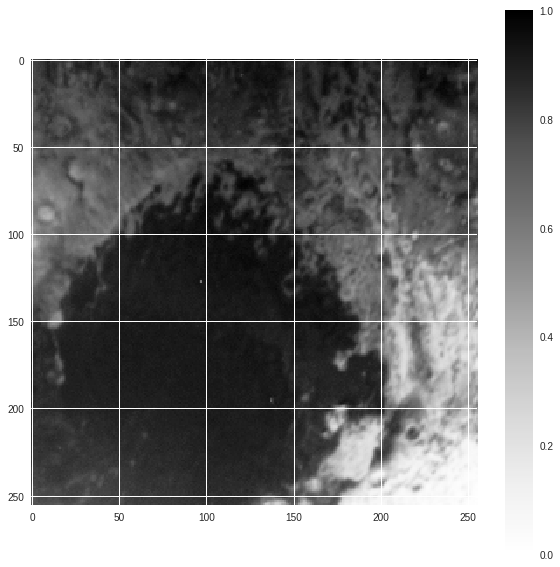

In [0]:
pluto = []
file = "cutoutlor_0299127173_0x630_eng.fit"
x = fits.open(file)[0].data[256:512,256:512]gal = []

x_shape = (x - np.min(x))/(np.max(x) - np.min(x))
pluto_torch = np_to_torch(x_shape).type(dtype)
pluto.append(pluto_torch)
figure = plt.figure(figsize=(10,10))
plt.imshow(x_shape)
plt.colorbar()  
plt.show()
  

In [0]:
pluto = torch.stack(pluto)
pluto.shape

torch.Size([1, 1, 256, 256])

In [0]:
net_input = get_noise(input_depth, INPUT, (pluto.shape[2] * factor, pluto.shape[3] * factor)).type(dtype).detach()

NET_TYPE = 'skip' # UNet, ResNet

net = get_net(input_depth,'skip', pad,
              n_channels=1,
              skip_n33d=128, 
              skip_n33u=128, 
              skip_n11=4, 
              num_scales=5,
              upsample_mode='bilinear').type(dtype)
#down_net = []

#for i in range(gal.shape[0]):
 # down_net.append(make_down_net().type(dtype))
#downsampler = Downsampler(n_planes=1, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

In [0]:
mse = torch.nn.MSELoss().type(dtype)

img_LR_var = gal.type(dtype)
img_LR_var.shape

torch.Size([1, 1, 256, 256])

In [0]:
from google.colab import files
psnr_history = [] 
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()



In [0]:
HR = net(net_input)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:
HR.shape

torch.Size([1, 1, 1024, 1024])

In [0]:
LR= stn_model(HR)

torch.Size([1, 1, 1024, 1024])
1torch.Size([1, 32, 1024, 1024])
2torch.Size([1, 32, 1024, 1024])
3torch.Size([1, 32, 1024, 1024])
4torch.Size([1, 32, 1024, 1024])
5torch.Size([1, 32, 1024, 1024])
6torch.Size([1, 32, 1024, 1024])
Pre view size:torch.Size([1, 32, 1024, 1024])
torch.Size([65536, 1024])
torch.Size([65536, 6])
torch.Size([65536, 2, 3])


RuntimeError: ignored

In [0]:
LR.shape

In [0]:
def closure():
    global i, net_input, k, output_list
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_HR_np = torch_to_np(out_HR)
    #out_LR = downsampler(out_HR)
   
    for k in range(len(gal)):
      out_LR = down_net[k](out_HR)
      if k == 0:
        total_loss = mse(out_LR[0], img_LR_var[k]) 
      else:
        total_loss += mse(out_LR[0], img_LR_var[k]) 
    
    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)
        
    total_loss.backward(retain_graph=True)

    if i % 100 == 0:
      output_list.append(out_HR_np) 
      print(i)
      out_HR_np = torch_to_np(out_HR)
      print(out_HR_np.shape)
      print("total loss = ",total_loss)
      
      figure = plt.figure(figsize=(10,10))
      plt.imshow(out_HR_np[0])
      plt.colorbar(fraction = 0.046)
      plt.title("Ouput")
      
      plt.show()
   
    i += 1
    
    return total_loss


In [0]:
i = 0
output_list = []

net_list = [net] + down_net
p = get_params(OPT_OVER, net_list, net(net_input))
    
optimize(OPTIMIZER, p, closure, LR, 2000)

In [0]:
out_HR = net(net_input)
out_HR_np = torch_to_np(out_HR)
output_list.append(out_HR_np) 

In [0]:
data, hdr = fits.getdata("cutout_SloanR_2017-03-25-T13110630_11_light_ds_ff.fits", 0, header=True)

for i in range(len(output_list)):
  fits.writeto(str(i)+'anneal_lr_SR_SloanR.fits', output_list[i], header=hdr, overwrite =True)
  files.download(str(i)+'anneal_lr_SR_SloanR.fits')

In [0]:
#out_LR = down_net[0](out_HR)#out_LR_np = torch_to_np(out_LR)figure = plt.figure(figsize=(10,10))plt.imshow(out_HR_np[0])plt.colorbar(fraction = 0.046)
asdfasdfplt.title(" Ouput")

plt.show()



In [0]:
figure = plt.figure(figsize=(10,10))
plt.imshow(torch_to_np(out_LR[0] - img_LR_var[0]))
plt.colorbar(fraction = 0.046)
plt.title("Downsampled Ouput - input")

plt.show()



In [0]:
fadsfrom google.colab import files
data, hdr = fits.getdata("GT_jbnya2suq_drc.fits", 0, header=True)
fits.writeto('down_nov1_satellite.fits', out_HR_np, header=hdr, overwrite =True)
files.download('down_nov1_satellite.fits')


In [0]:
#fits.writeto("GT_satellite.fits", x, header=hdr, overwrite =True)
#files.download("GT_satellite.fits")


In [0]:
#fits.writeto("LR_satellite.fits", torch_to_np(sat)[0], header=hdr, overwrite =True)
#files.download("LR_satellite.fits")

In [0]:
zebra = img = Image.open('deepimgprior.png')
figure = plt.figure(figsize=(20,10))
plt.imshow(zebra)
plt.show()

In [0]:
pria

In [0]:
out_LR = downsampler(out_HR)
total_loss = mse(out_LR, img_LR_var[:,:,k,:,:])
total_loss + mse(out_LR, img_LR_var[:,:,2,:,:]) + mse(out_LR, img_LR_var[:,:,4,:,:])

In [0]:
for i in range (len(sat)):
  fits.writeto('LR_100_sat' + str(i) + '.fits', sat[i], header=hdr, overwrite =True)
  fits.writeto('noise_100_sat' + str(i) + '.fits', noise_l[i], header=hdr, overwrite =True)
  files.download('LR_100_sat' + str(i) +'.fits')
  files.download('noise_100_sat' + str(i) +'.fits')

In [0]:
fits.writeto('GT_jbnya2suq_drc.fits', x, header=hdr, overwrite =True)
files.download('GT_jbnya2suq_drc.fits')

In [0]:


plt.subplot(2,2,1)
plt.imshow(out_HR_np[0])
plt.colorbar(fraction = 0.046)#,orientation='horizontal')
plt.title("Output")
      
norm = ImageNormalize(out_HR_np[0], interval = ZScaleInterval())
plt.subplot(2,2,2)
plt.imshow(out_HR_np[0],norm=norm)
x = plt.colorbar(fraction = 0.046)#,orientation='horizontal')
plt.title("Z-Scale of Output")
 
out_LR = downsampler(out_HR)
  
diff = torch_to_np(out_LR)[0]-gal[k]

plt.subplot(2,2,3)
plt.imshow(np.absolute(diff))
plt.colorbar(fraction = 0.046)
plt.show()

normd=ImageNormalize(diff, interval = ZScaleInterval())
xd,yd = z.get_limits(diff)

plt.subplot(2,2,4)
plt.imshow(np.absolute(diff),norm = normd)
plt.colorbar(fraction = 0.046)#,orientation='horizontal')
plt.title("Zscale Diff. Output and Original")

plt.tight_layout(pad=0.5)
plt.show()
   
     
      

In [0]:
#for j in range(len(sky_l)):
 # scipy.misc.imsave('sky_l' + str(j) +'.png',sky_l[j])
  #files.download('sky_l' + str(j) +'.png')

In [0]:
#for i in range(10):
 # nrmd=ImageNormalize(orig_kerns[i], interval = ZScaleInterval())
  #plt.subplot(221)
  plt.imshow(orig_kerns[i],norm =nrmd)
  plt.colorbar(fraction = 0.046)#,orientation='horizontal')
  plt.title("Input Zscale")
  
  nrmd=ImageNormalize(out_HR_np[0], interval = ZScaleInterval())
  plt.subplot(222)
  plt.imshow(out_HR_np[0],norm =nrmd)
  plt.colorbar(fraction = 0.046)#,orientation='horizontal')
  plt.title("Output Zscale")
  
  diffs = (out_HR_np[0] - orig_kerns[i])
  normd=ImageNormalize(diffs, interval = ZScaleInterval())

  plt.subplot(223)
  plt.imshow(np.absolute(diffs),norm = normd)
  plt.colorbar(fraction = 0.046)#,orientation='horizontal')
  plt.title("Zscale Diff. Output and Original %i" %(i + 1))
  plt.tight_layout(pad=0.5)
  plt.show()